<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/object-detection/eager_few_shot_od_training_tf2_colab_dataset_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

## Imports

In [1]:
# !pip install -U --pre tensorflow=="2.2.0"

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3129, done.
remote: Counting objects: 100% (3129/3129), done.
remote: Compressing objects: 100% (2454/2454), done.
remote: Total 3129 (delta 833), reused 1496 (delta 631), pack-reused 0
Receiving objects: 100% (3129/3129), 33.34 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (833/833), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1684828 sha256=977513cb6465d167119ab59a656cd07960569232eafcb4370f964d8c8eb5d6dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ljw7semk/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=00233412043e230d8d0553b7882e018d9b595f6d21a1133714fac4fd890aa179
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=0f62625101b1f6c4374ff11e9c451038e8efc45c6229a10c609e935811757a27
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=7c77df6c2ff07b5fbbbd7b2300c5c913a2222998327392f7a1

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

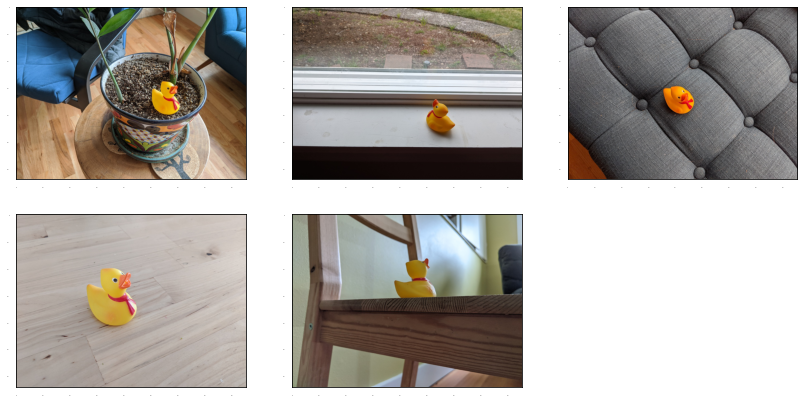

In [6]:
# Load images and visualize
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
  image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [7]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [8]:
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [9]:

# # By convention, our non-background classes start counting at 1.  Given
# # that we will be predicting just one class, we will therefore assign it a
# # `class id` of 1.
# duck_class_id = 1
# num_classes = 1

# category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# # Convert class labels to one-hot; convert everything to tensors.
# # The `label_id_offset` here shifts all classes by a certain number of indices;
# # we do this here so that the model receives one-hot labels where non-background
# # classes start counting at the zeroth index.  This is ordinarily just handled
# # automatically in our training binaries, but we need to reproduce it here.
# label_id_offset = 1
# train_image_tensors = []
# gt_classes_one_hot_tensors = []
# gt_box_tensors = []
# for (train_image_np, gt_box_np) in zip(
#     train_images_np, gt_boxes):
#   train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
#       train_image_np, dtype=tf.float32), axis=0))
#   gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
#   zero_indexed_groundtruth_classes = tf.convert_to_tensor(
#       np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
#   gt_classes_one_hot_tensors.append(tf.one_hot(
#       zero_indexed_groundtruth_classes, num_classes))
# print('Done prepping data.')


In [10]:
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

gt_labels=np.array([[1.],[1.],[1.],[1.],[1.]], dtype=np.float32)
train_labels=(gt_labels, gt_boxes)

In [11]:
type(gt_labels)
gt_boxes=np.array(gt_boxes, dtype=np.float32)
print(gt_boxes.shape)
print(gt_labels.shape)

(5, 1, 4)
(5, 1)


In [12]:
train_images_np=np.array(train_images_np, dtype=np.float32)
train_images_np.shape

(5, 640, 853, 3)

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images_np, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [14]:
batch_size = 1#@param {type:"integer"}
image_height = 640#@param {type:"integer"}
image_width =  640#@param {type:"integer"}


In [15]:
def resize_image(image, label):
    image = tf.image.resize(image, [image_height, image_width])
    return  image, label

train_ds = train_ds.map(resize_image)
# test_ds = test_ds.map(resize_image)
# val_ds = val_ds.map(resize_image)


## 4. Configure Dataset for Performance
---

**Configure the Dataset for Performance**

Some essential data transformations were already performed by `image_dataset_from_directory`. 

That includes **`batching`**, **`image format decoding`**, **`splitting`** and `resizing`.

Those transformation were essential for the execution of the network.


Next transormations are needed to improve performance:


- **cache** -  keeps the images in memory after they're loaded off disk during 
the first epoch.

- **shuffle** - fills a buffer with buffer_size elements, then randomly samples elements from this buffer. The sampled elements are replaced by new dataset elements as depicted in the diagram below. 

- **prefetch** -  overlaps data preprocessing and model execution while training. (The tf.data.AUTOTUNE parameter defines a dynamic tuning of the number of prefetched data elements. The number depends on the number of batches consumed in a single step, i.e. on parallelism extent). In case both **perfecth** and **shuffle** are set, the shuffle buffer should be greater than or equal to the full size of the dataset.

- **normalization** - standardizes the inputs to the range [0,1], which improves performance.


- **augmentation** - expands training dataset, increases the diversity of training set, by applying transformations, such as image rotation, flips, shifts, and shear.




In [16]:
def configure_for_performance(ds):
  # ds = ds.cache()
  ds = ds.shuffle(buffer_size=500)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)


In [17]:
train_ds

<PrefetchDataset shapes: ((1, 640, 640, 3), ((1, 1), (1, 1, 4))), types: (tf.float32, (tf.float32, tf.float32))>

#####Visualize Data Examples

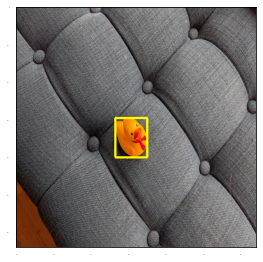

In [18]:
import PIL
from PIL import Image, ImageDraw

def draw_bounding_box(image, ymin, xmin, ymax, xmax, color, thickness=3):
  draw = ImageDraw.Draw(image)
  draw.line([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin),
             (xmin, ymin)],
            width=thickness,
            fill=color)
  return image

# get_label_name = info.features['label'].int2str
plt.figure(figsize=(15, 15))

images, labels = next(iter(train_ds))
class_categories, boxes = labels
for idx, (image, class_cat, bbox) in enumerate(zip(images, class_categories, boxes)):
  ax = plt.subplot(3, 3, idx+1)
  image_pil = Image.fromarray(np.uint8(image.numpy()))
  im_width, im_height = image_pil.size
  ymin, xmin, ymax, xmax = ((bbox) * [im_height, im_width, im_height, im_width])[0]
  draw_bounding_box(image_pil, ymin, xmin, ymax, xmax, color=(255,255,0), thickness=6)
  ax.imshow(image_pil)
  # ax.set_title(class_names[np.argmax(class_cat)])

Set Augmentation to training dataset

In [19]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Let's just visualize the rubber duckies as a sanity check


In [20]:
# dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

# plt.figure(figsize=(30, 15))
# for idx in range(5):
#   plt.subplot(2, 3, idx+1)
#   plot_detections(
#       train_images_np[idx],
#       gt_boxes[idx],
#       np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
#       dummy_scores, category_index)
# plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [21]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-01-25 16:32:36--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.133.128, 2a00:1450:400c:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.133.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  76.9MB/s    in 3.0s    

2022-01-25 16:32:40 (76.9 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [22]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [23]:
# tf.keras.backend.set_learning_phase(True)

# # These parameters can be tuned; since our training set has 5 images
# # it doesn't make sense to have a much larger batch size, though we could
# # fit more examples in memory if we wanted to.
# batch_size = 4
# learning_rate = 0.01
# num_batches = 100

# # Select variables in top layers to fine-tune.
# trainable_variables = detection_model.trainable_variables
# to_fine_tune = []
# prefixes_to_train = [
#   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
#   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
# for var in trainable_variables:
#   if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
#     to_fine_tune.append(var)

# # Set up forward + backward pass for a single train step.
# def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
#   """Get a tf.function for training step."""

#   # Use tf.function for a bit of speed.
#   # Comment out the tf.function decorator if you want the inside of the
#   # function to run eagerly.
#   @tf.function
#   def train_step_fn(image_tensors,
#                     groundtruth_boxes_list,
#                     groundtruth_classes_list):
#     """A single training iteration.

#     Args:
#       image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
#         Note that the height and width can vary across images, as they are
#         reshaped within this function to be 640x640.
#       groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
#         tf.float32 representing groundtruth boxes for each image in the batch.
#       groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
#         with type tf.float32 representing groundtruth boxes for each image in
#         the batch.

#     Returns:
#       A scalar tensor representing the total loss for the input batch.
#     """
#     shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
#     model.provide_groundtruth(
#         groundtruth_boxes_list=groundtruth_boxes_list,
#         groundtruth_classes_list=groundtruth_classes_list)
#     with tf.GradientTape() as tape:
#       preprocessed_images = tf.concat(
#           [detection_model.preprocess(image_tensor)[0]
#            for image_tensor in image_tensors], axis=0)
#       prediction_dict = model.predict(preprocessed_images, shapes)
#       losses_dict = model.loss(prediction_dict, shapes)
#       total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
#       gradients = tape.gradient(total_loss, vars_to_fine_tune)
#       optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
#     return total_loss

#   return train_step_fn

# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
# train_step_fn = get_model_train_step_function(
#     detection_model, optimizer, to_fine_tune)

# print('Start fine-tuning!', flush=True)
# for idx in range(num_batches):
#   # Grab keys for a random subset of examples
#   all_keys = list(range(len(train_images_np)))
#   random.shuffle(all_keys)
#   example_keys = all_keys[:batch_size]

#   # Note that we do not do data augmentation in this demo.  If you want a
#   # a fun exercise, we recommend experimenting with random horizontal flipping
#   # and random cropping :)
#   gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
#   gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
#   image_tensors = [train_image_tensors[key] for key in example_keys]

#   # Training step (forward pass + backwards pass)
#   total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

#   if idx % 10 == 0:
#     print('batch ' + str(idx) + ' of ' + str(num_batches)
#     + ', loss=' +  str(total_loss.numpy()), flush=True)

# print('Done fine-tuning!')

## Train Function



In [24]:
tf.keras.backend.set_learning_phase(True)


learning_rate = 0.01

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def batch_train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    # shapes = tf.constant(batch_size * [[image_height, image_width, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)


    with tf.GradientTape() as tape:
      # preprocessed_images = tf.concat(
      #     [detection_model.preprocess(image_tensor)[0]
      #      for image_tensor in image_tensors], axis=0)

      preprocessed_image, shapes = detection_model.preprocess(image_tensors)
  # prediction_dict = detection_model.predict(preprocessed_image, shapes)
  # return detection_model.postprocess(prediction_dict, shapes)


      preprocessed_images = image_tensors
      prediction_dict = model.predict(preprocessed_images, shapes)
      
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return batch_train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
batch_train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)


/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


##Do Fine Tuning

In [29]:
def train_data_for_one_epoch():
  losses = []
  total_loss = None
  # pbar = tqdm(total=len(list(enumerate(train_ds))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  epochs = 100
  for epoch in range(epochs):
    print(f'epoch={epoch}')
    for step, (image_batch_train, label_batch_train) in enumerate(train_ds):
        classes, boxes = label_batch_train
        classes=tf.expand_dims(classes, axis=1)
        # shapes = tf.constant(batch_size * [[image_height, image_width, 3]], dtype=tf.int32)
        boxes_list = [box for box in boxes]
        classes_list = [aclass for aclass in classes]
        total_loss = batch_train_step_fn(image_batch_train, boxes_list, classes_list)
        # losses.append(total_loss.numpy())
        # if step % 1 == 0:
        #   print('batch ' + str(step) + ' of ' + str(1)
        #   + ', loss=' +  str(total_loss.numpy()), flush=True)
        # pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        # pbar.update()
    losses.append(total_loss.numpy())
    # if step % 1 == 0:
    print('Epoch ' + str(epoch) + ' of ' + str(epochs)
          + ', loss=' +  str(total_loss.numpy()), flush=True)
  return losses

In [48]:
train_data_for_one_epoch()

epoch=0
Epoch 0 of 100, loss=1.1425382
epoch=1
Epoch 1 of 100, loss=3.5683606
epoch=2
Epoch 2 of 100, loss=3.7527673
epoch=3
Epoch 3 of 100, loss=1.659645
epoch=4
Epoch 4 of 100, loss=0.15015908
epoch=5
Epoch 5 of 100, loss=1.1610284
epoch=6
Epoch 6 of 100, loss=0.47981095
epoch=7
Epoch 7 of 100, loss=0.957628
epoch=8
Epoch 8 of 100, loss=0.27694255
epoch=9
Epoch 9 of 100, loss=0.119427264
epoch=10
Epoch 10 of 100, loss=0.006137854
epoch=11
Epoch 11 of 100, loss=0.017034065
epoch=12
Epoch 12 of 100, loss=0.020011274
epoch=13
Epoch 13 of 100, loss=0.06521942
epoch=14
Epoch 14 of 100, loss=0.0040877843
epoch=15
Epoch 15 of 100, loss=0.0054832413
epoch=16
Epoch 16 of 100, loss=0.008501832
epoch=17
Epoch 17 of 100, loss=0.0041007954
epoch=18
Epoch 18 of 100, loss=0.0019048443
epoch=19
Epoch 19 of 100, loss=0.0004565682
epoch=20
Epoch 20 of 100, loss=0.0014953145
epoch=21
Epoch 21 of 100, loss=0.0005963648
epoch=22
Epoch 22 of 100, loss=0.0005456036
epoch=23
Epoch 23 of 100, loss=0.00085477

[1.1425382,
 3.5683606,
 3.7527673,
 1.659645,
 0.15015908,
 1.1610284,
 0.47981095,
 0.957628,
 0.27694255,
 0.119427264,
 0.006137854,
 0.017034065,
 0.020011274,
 0.06521942,
 0.0040877843,
 0.0054832413,
 0.008501832,
 0.0041007954,
 0.0019048443,
 0.0004565682,
 0.0014953145,
 0.0005963648,
 0.0005456036,
 0.00085477997,
 0.0007649057,
 0.00033109097,
 0.00045735505,
 0.00043594965,
 0.00030081221,
 0.00042335375,
 0.00028701915,
 0.0008382609,
 0.00040614663,
 0.0004005433,
 0.00039259027,
 0.0003886349,
 0.00075112487,
 0.0007417097,
 0.00044906655,
 0.00037131886,
 0.00023973983,
 0.0003606182,
 0.00023270676,
 0.00022949897,
 0.00035202122,
 0.00034602324,
 0.00064293284,
 0.00021728006,
 0.0003813005,
 0.00033251793,
 0.00033032082,
 0.00032770156,
 0.00032509255,
 0.00020221704,
 0.000576444,
 0.00031667305,
 0.0003422583,
 0.00031472626,
 0.00030880992,
 0.00032965027,
 0.0001872446,
 0.00032408588,
 0.00030300498,
 0.00031775053,
 0.00029911535,
 0.00017834757,
 0.00029496

In [36]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [32]:
# len(train_ds)
# itr = iter(train_ds)
# image_batch_train, label_batch_train =  itr.get_next()

In [33]:
# img=tf.expand_dims(image_batch_train[0], axis=0)
# preprocessed_image, shapes = detection_model.preprocess(img)
# prediction_dict = detection_model.predict(preprocessed_image, shapes)
# detections = detection_model.postprocess(prediction_dict, shapes)

In [ ]:
# label_id_offset = 1
# category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# plot_detections(
#       image_batch_train[0],
#       detections['detection_boxes'][0].numpy(),
#       detections['detection_classes'][0].numpy().astype(np.uint32)
#       + label_id_offset,
#       detections['detection_scores'][0].numpy(),
#       category_index, figsize=(15, 20))

In [49]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
duck_class_id = 1
# num_classes = 1
category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [47]:
detections.keys()
detections['detection_boxes']
np.argmax(detections['detection_scores'][0].numpy())
detections['detection_scores'][0].numpy()[0]

0.032133155

# Load test images and run inference with new model!

In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))